In [1]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model parameters
img_height = 224
img_width = 224
batch_size = 32
num_classes = 3  # mildly demented, moderately demented, nondemented


# Directory paths
data_dir = './data_split/'

def filter_directories(directory):
    """ 
    Returns a list of directories that contain all three image types: 'cor', 'sag', 'tra'.
    """
    filtered_dirs = []
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            for patient_dir in os.listdir(class_path):
                patient_path = os.path.join(class_path, patient_dir)
                if os.path.isdir(patient_path):
                    image_types = os.listdir(patient_path)
                    if all(x in image_types for x in ['tra', 'cor', 'sag']):
                        filtered_dirs.append(patient_path)
    return filtered_dirs

# Modify the ImageDataGenerator to not use the 'validation_split'
datagen = ImageDataGenerator(rescale=1./255)

# Use the directory filter function to get the list of valid directories
valid_training_dirs = filter_directories(data_dir + 'training')
valid_validation_dirs = filter_directories(data_dir + 'validation')

# Create a custom generator to handle the multi-directory structure
def custom_generator(generator, directories):
    while True:
        for directory in directories:
            for x, y in generator.flow_from_directory(
                directory,
                target_size=(img_height, img_width),
                batch_size=batch_size,
                class_mode='categorical'  # as we have multiple classes
            ):
                yield x, y

# Update directory paths
train_dir = './data_split/data_train/training/'
val_dir = './data_split/data_val/validation/'

# Image Data Generator
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Calculate steps per epoch and validation steps
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # You can adjust the number of epochs
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Found 685 images belonging to 3 classes.
Found 231 images belonging to 3 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [24]:
%pip install opencv-python

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/a1/f6/57de91ea40c670527cd47a6548bf2cbedc68cec57c041793b256356abad7/opencv_python-4.8.1.78-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 33.4 MB/s eta 0:00:0000:0100:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew o

In [62]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def image_mask_generator(image_dir, mask_dir, batch_size, target_size):
    image_datagen = ImageDataGenerator(rescale=1./255)
    mask_datagen = ImageDataGenerator(rescale=1./255)

    image_generator = image_datagen.flow_from_directory(
        image_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode='rgb',
        shuffle=True  # Ensuring images are shuffled
    )

    mask_generator = mask_datagen.flow_from_directory(
        mask_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode='grayscale',
        shuffle=True  # Ensuring masks are shuffled in the same way as images
    )

    print(f"Found {image_generator.samples} images.")
    print(f"Found {mask_generator.samples} masks.")

    while True:
        try:
            imgs_batch = image_generator.next()
            masks_batch = mask_generator.next()
        except StopIteration:
            # If the generator ends for some reason, restart it
            print("Restarting generator...")
            image_generator.reset()
            mask_generator.reset()
            continue

        # Resize masks to add an extra dimension if they don't have it
        masks_batch = masks_batch[..., np.newaxis] if masks_batch.ndim == 3 else masks_batch
        
        print(f"Yielding batch: imgs {imgs_batch.shape}, masks {masks_batch.shape}")
        
        yield imgs_batch, masks_batch

        

# Corrected directory paths
train_image_dir = './data_split/data_train/training'  # Parent directory containing 'mildly demented', etc.
train_mask_dir = './FSL_data_split/training/'  # Assuming this is correct
val_image_dir = './data_split/data_valid/validation'  # Parent directory for validation images
val_mask_dir = './FSL_data_split/validation/'  # Assuming this is correct


# Parameters
batch_size = 16
img_height = 256
img_width = 256

# Create generators
train_generator = image_mask_generator(train_image_dir, train_mask_dir, batch_size, (img_height, img_width))
val_generator = image_mask_generator(val_image_dir, val_mask_dir, batch_size, (img_height, img_width))


Found 685 images belonging to 3 classes.
Found 162 images belonging to 3 classes.


Found 685 images.
Found 162 masks.
Yielding batch: imgs (16, 256, 256, 3), masks (16, 256, 256, 1)
(16, 256, 256, 3) (16, 256, 256, 1)


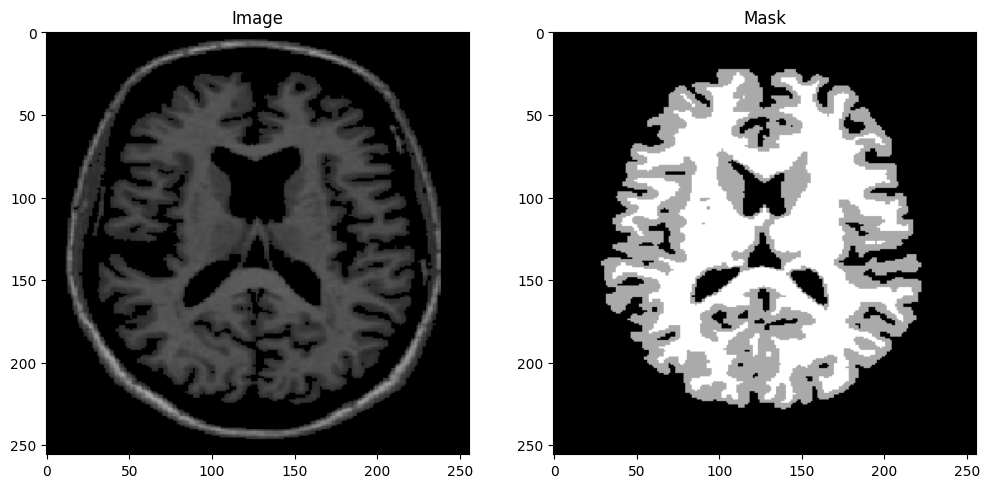

In [63]:
# Test the generator output
x, y = next(train_generator)
print(x.shape, y.shape)  # Check the shape of the output

import matplotlib.pyplot as plt

# Display the first image and mask from the batch
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(x[0])
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(y[0].squeeze(), cmap='gray')
plt.title('Mask')
plt.show()

In [35]:
test_images, test_masks = next(train_generator)
print("Test Image batch shape:", test_images.shape)
print("Test Mask batch shape:", test_masks.shape)
print(os.listdir(train_mask_dir))


Found 685 images belonging to 3 classes.
Found 162 images belonging to 3 classes.


Found 162 mask images.
Test Image batch shape: (16, 256, 256, 3)
Test Mask batch shape: (16, 256, 256, 1)
['moderately demented', 'mildly demented', 'nondemented']


In [67]:
def image_mask_generator(image_dir, mask_dir, batch_size, target_size):


    # Verify directories before proceeding
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(mask_dir):
        raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

    image_datagen = ImageDataGenerator(rescale=1./255)
    mask_datagen = ImageDataGenerator(rescale=1./255)

    image_generator = image_datagen.flow_from_directory(
        image_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode='rgb',
        shuffle=True
    )

    mask_generator = mask_datagen.flow_from_directory(
        mask_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode='grayscale',
        shuffle=True
    )

    print(f"Found {image_generator.samples} image files.")
    print(f"Found {mask_generator.samples} mask files.")

    while True:
        try:
            imgs_batch = image_generator.next()
            masks_batch = mask_generator.next()
            masks_batch = np.expand_dims(masks_batch.squeeze(), axis=-1)

            print(f"Yielding batch - Image batch shape: {imgs_batch.shape}, Mask batch shape: {masks_batch.shape}")

            yield imgs_batch, masks_batch
        except Exception as e:
            print(f"An error occurred: {e}")
            break


In [69]:
# Test the first few batches from the training generator
for i in range(10):  # Adjust this number to test more or fewer batches
    try:
        images, masks = train_generator[i]
        print(f"Batch {i}:")
        print(f"  Images shape: {images.shape}")
        print(f"  Masks shape: {masks.shape}")
    except Exception as e:
        print(f"Error occurred for batch {i}: {e}")


Error occurred for batch 0: 'generator' object is not subscriptable
Error occurred for batch 1: 'generator' object is not subscriptable
Error occurred for batch 2: 'generator' object is not subscriptable
Error occurred for batch 3: 'generator' object is not subscriptable
Error occurred for batch 4: 'generator' object is not subscriptable
Error occurred for batch 5: 'generator' object is not subscriptable
Error occurred for batch 6: 'generator' object is not subscriptable
Error occurred for batch 7: 'generator' object is not subscriptable
Error occurred for batch 8: 'generator' object is not subscriptable
Error occurred for batch 9: 'generator' object is not subscriptable


In [71]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

def upsample_concat(block, bridge):
    up = Conv2DTranspose(block.shape[-1], (2, 2), strides=(2, 2), padding='same')(block)
    return concatenate([up, bridge])

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Downsampling
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 128)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    b = conv_block(p4, 256)

    # Upsampling
    u1 = upsample_concat(b, c4)
    c5 = conv_block(u1, 128)
    u2 = upsample_concat(c5, c3)
    c6 = conv_block(u2, 64)
    u3 = upsample_concat(c6, c2)
    c7 = conv_block(u3, 32)
    u4 = upsample_concat(c7, c1)
    c8 = conv_block(u4, 16)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the U-Net model
model = unet_model()

# Assuming train_generator and val_generator are defined as per your previous setup
train_image_count = len(os.listdir('./FSL_data_split/training'))
val_image_count = len(os.listdir('./FSL_data_split/validation'))

batch_size = 7
epochs = 10

# Calculate steps per epoch for training and validation
steps_per_epoch = train_image_count // batch_size
validation_steps = val_image_count // batch_size

# Adjust steps if there are remaining images
if train_image_count % batch_size != 0:
    steps_per_epoch += 1
if val_image_count % batch_size != 0:
    validation_steps += 1

# Train the model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)


Yielding batch: imgs (16, 256, 256, 3), masks (2, 256, 256, 1)
Epoch 1/10
Yielding batch: imgs (16, 256, 256, 3), masks (16, 256, 256, 1)
Yielding batch: imgs (16, 256, 256, 3), masks (16, 256, 256, 1)


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/binary_crossentropy/logistic_loss/mul/BroadcastGradientArgs defined at (most recent call last):
  File "/opt/homebrew/Cellar/python@3.9/3.9.17_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/opt/homebrew/Cellar/python@3.9/3.9.17_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1046, in launch_instance

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/homebrew/Cellar/python@3.9/3.9.17_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/opt/homebrew/Cellar/python@3.9/3.9.17_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/opt/homebrew/Cellar/python@3.9/3.9.17_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/var/folders/nr/9dz9m8pd2752bz2rmpkbrcs40000gn/T/ipykernel_21289/1641384109.py", line 66, in <module>

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1130, in train_step

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 598, in minimize

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 656, in _compute_gradients

  File "/Users/msturman00/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 532, in _get_gradients

Incompatible shapes: [16,256,256,1] vs. [2,256,256,1]
	 [[{{node gradient_tape/binary_crossentropy/logistic_loss/mul/BroadcastGradientArgs}}]] [Op:__inference_train_function_45811]

In [65]:
print(os.getcwd())


/Users/msturman00/Documents/GitHub/alzheimer-classification
